# Установка нужных библиотек

In [92]:
import warnings
warnings.filterwarnings("ignore")

# try:
#     import google.colab
#     IN_COLAB = True
# except:
#     IN_COLAB = False

# if IN_COLAB:
#     !git clone -qq https://github.com/Intelligent-Systems-Phystech/ProjectTemplate.git /tmp/repo
#     !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

# Импорт библиотек

In [93]:
from sklearn.datasets import make_moons, make_circles

import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal, Normal

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [94]:
N_SAMPLES = 1_500

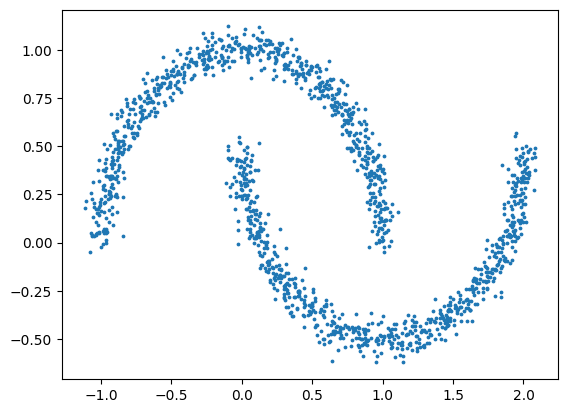

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [95]:
moons = torch.tensor(make_moons(N_SAMPLES, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()
moons.shape
moons = moons.to('cuda')
moons.dtype

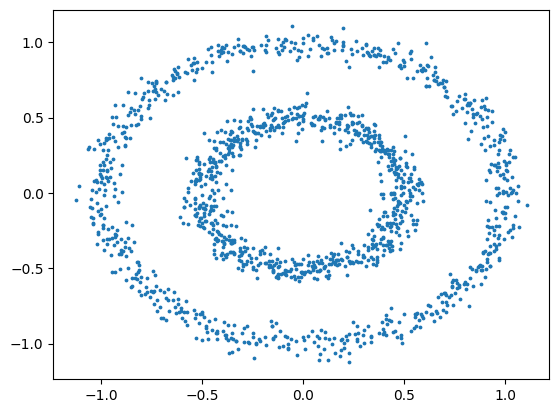

(1500, 2)

In [ ]:
circles = make_circles(N_SAMPLES, noise=0.05, factor=0.5)[0]
plt.scatter(circles[:, 0], circles[:, 1], s=3)
plt.show()
circles.shape

In [ ]:
normal = MultivariateNormal(torch.zeros(2).to('cuda'), torch.eye(2).to('cuda'))
norm_samples = normal.sample([N_SAMPLES])
# plt.scatter(norm_samples[:, 0], norm_samples[:, 1], s=3)
# plt.show()

norm_samples.dtype

torch.float32

In [ ]:
normal_1 = Normal(5, 1)
norm_1 = normal_1.sample([N_SAMPLES])

normal_2 = Normal(-2, 2)
norm_2 = normal_2.sample([N_SAMPLES])

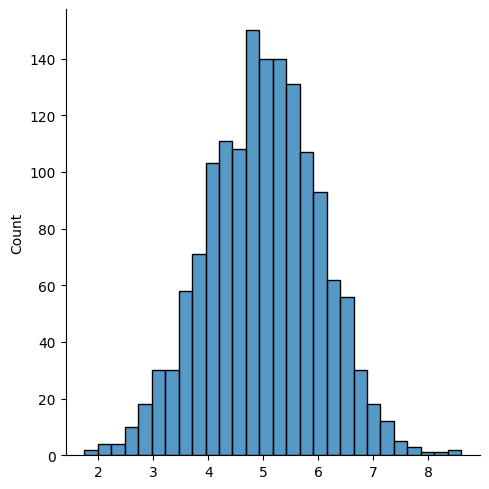

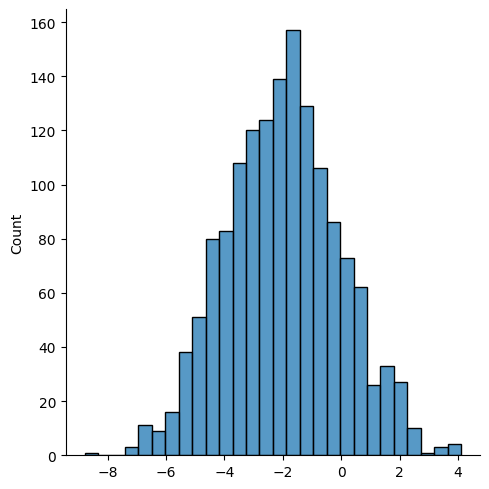

In [ ]:
sns.displot(norm_1)
sns.displot(norm_2)

norm_1 = norm_1.to('cuda')
norm_2 = norm_2.to('cuda')

## Algorithm
Заданной динамикой построить другую которая будет ограничена
Let we have dataset $\{y_j\}_{j=1}^m \forall y_j\in\mathbb{R}^2$ and we have latent distribution $\pi_0(x) = \mathcal{N}(0, I_2)$

$$
  \beta^* = \arg\max_\beta\frac1n\sum_{i=1}^n\log(\phi_1(y_i, \beta)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$

$$
  \alpha^* = \arg\max_\alpha\frac1m\sum_{j=1}^m\log(\hat\phi_0(x_j, \alpha)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$<br>

Now we have two functions $\phi_1(y, \beta^*), \hat\phi_0(x, \alpha^*)$ which can be used to calculate joint distribution $q^*(x, y)$<r>

To generata data $y$ we use
<!-- q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}  -->
$$
\pi^*_1(y) = \phi_1(y_j, \beta^*)\hat\phi_1(y)
$$
<br>
$$
q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}
$$



## Model
We will parametrize $\phi_1(y, \beta), \hat\phi_0(x, \alpha)$ with One-Layer NN with ReLU activation and 64 output size.

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(1, 32),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.Softplus()
    )

  def forward(self, x):
    x = x[:, None]
    return self.layers(x)

In [ ]:
EPOCHS = 250
INNER_STEP = 150

phi_0 = MLP()
phi_1 = MLP()

phi_0.to('cuda')
phi_1.to('cuda')

# Prior conditional  distribution p(y|x_s) = Normal(y | x_s, gamma*I)
# for sample in norm_samples:
gamma = 1000
y_x = Normal(norm_1, gamma * 1).sample([400]).to('cuda')

optimizer_forward = optim.Adam(phi_0.parameters(), lr=0.001)
optimizer_backward = optim.Adam(phi_1.parameters(), lr=0.001)

In [ ]:
losses = {
    'forward': [],
    'backward': []
}

samples_probs = normal_1.log_prob(norm_1).exp()[:, None]

for i in tqdm(range(EPOCHS)):
    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_forward.zero_grad()
        output = phi_0(norm_1)
        model_log = output.log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * output / samples_probs).mean(dim=0)

        loss_forward =  -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_forward.backward()
        optimizer_forward.step()
    losses['forward'].append(temp_loss/INNER_STEP)

    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_backward.zero_grad()
        model_log = phi_1(norm_2).log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * phi_0(norm_1) / samples_probs).mean(dim=0)

        loss_backward = -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_backward.backward()
        optimizer_backward.step()
    losses['backward'].append(temp_loss/INNER_STEP)


100%|██████████| 250/250 [06:17<00:00,  1.51s/it]


In [ ]:
losses

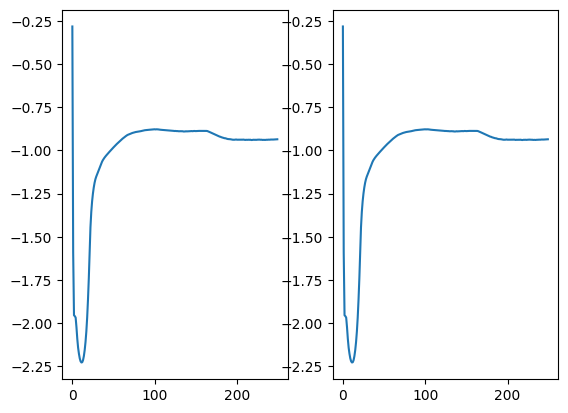

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(losses['forward'])
ax[1].plot(losses['forward'])

plt.show()

In [ ]:
phi_0.cpu()
phi_1.cpu()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [ ]:
phi_1(normal_1.sample([400])).mean(0)[:, None].shape

torch.Size([1, 1])

In [ ]:
test_samples_1 = normal_1.sample([1000])
test_samples_2 = normal_2.sample([1000])

test_probs = (phi_0(test_samples_1) * phi_1(test_samples_2)).detach().numpy().squeeze()


(torch.Size([1000]), (1000,))

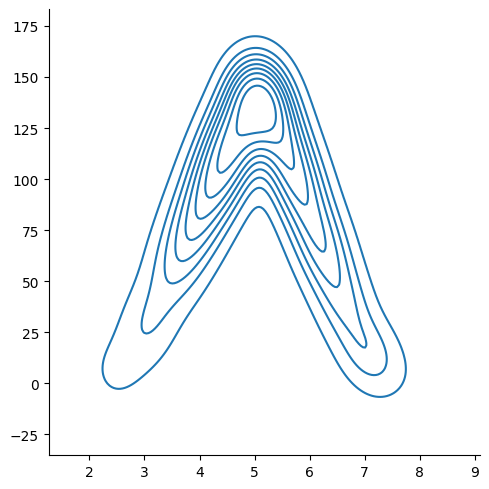

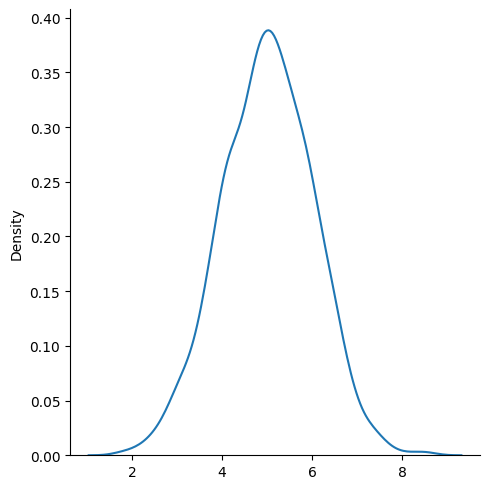

In [ ]:
sns.displot(x=test_samples, y=test_probs, kind='kde')
sns.displot(norm_1.cpu(), kind='kde')

## New experiments

In [ ]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons, make_circles

In [ ]:
def visualize_GAN(gan, real_data):
    num = 500
    real_data = pd.DataFrame(real_data, columns=['x', 'y'])
    samples = pd.DataFrame(gan.sample(num), columns=['x', 'y'])
    
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    sns.kdeplot(real_data, x='x', y='y', fill=True, ax=axs[0])
    sns.kdeplot(samples, x='x', y='y', fill=True, color='r', ax=axs[1])
    plt.show()

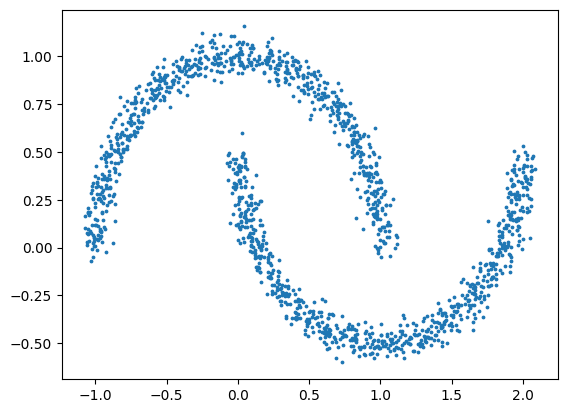

In [ ]:
moons = torch.tensor(make_moons(1500, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()

In [ ]:
class GAN():
    def __init__(self, n_latent=2, device='cpu'):
        self.gen = self._get_simple_model([n_latent, 32, 32, 32, 2]).to(device)
        self.disc = nn.Sequential(*self._get_simple_model([2, 32, 32, 32, 1], True), nn.Sigmoid()).to(device)
        self.noise_fn = lambda num: torch.normal(0, 1, size=(num, self.n_latent), device=device)

        self.n_latent = n_latent
        self.device = device
        
    def sample(self, num=1000):
        latent_vec = self.noise_fn(num)
        with torch.no_grad():
            samples = self.gen(latent_vec)
        return samples.cpu().numpy()

    def _get_simple_model(self, hiddens, disc=False):
        assert len(hiddens) > 1
        activation = nn.LeakyReLU() if disc else nn.ReLU()
        modules = []
        for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
            modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
        modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
        return nn.Sequential(*modules)

In [ ]:
class GANTrainer():
    def __init__(self, model, batch_size=32, lr_disc=1e-3, lr_gen=2e-4):
        self.model = model
        self.batch_size = batch_size
        self.device = model.device
        self.criterion = nn.BCELoss()
        self.optim_disc = torch.optim.Adam(model.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam(model.gen.parameters(), lr=lr_gen)

    def _train_step_gen(self):
        """Train the generator one step and return the loss."""
        self.model.gen.zero_grad()
        
        latent_vec = self.model.noise_fn(self.batch_size)
        generated = self.model.gen(latent_vec)
        classifications = self.model.disc(generated)
        loss = self.criterion(classifications, torch.ones((self.batch_size, 1)).to(self.device))
        
        loss.backward()
        self.optim_gen.step()
        return loss.item()

    def _train_step_disc(self, real_data):
        """Train the discriminator one step and return the losses."""
        self.model.disc.zero_grad()

        pred_real = self.model.disc(real_data)
        loss_real = self.criterion(pred_real, torch.ones((self.batch_size, 1)).to(self.device))

        latent_vec = self.model.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.model.gen(latent_vec)
        pred_fake = self.model.disc(fake_samples)
        loss_fake = self.criterion(pred_fake, torch.zeros((self.batch_size, 1)).to(self.device))

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        
        return loss_real.item(), loss_fake.item()

    def _train_step(self, real_data):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(real_data)
        loss_gen = self._train_step_gen()
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for batch in dataloader:
                self.batch_size = batch.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(batch.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [ ]:
BATCH_SIZE = 32
EPOCHS = 200
LR_D = 1e-4
LR_G = 3e-5
N_LATENS = 2

dataloader = DataLoader(moons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan = GAN(N_LATENS, device='cuda')

trainer = GANTrainer(gan, batch_size=BATCH_SIZE, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/200 [00:00<?, ?it/s]

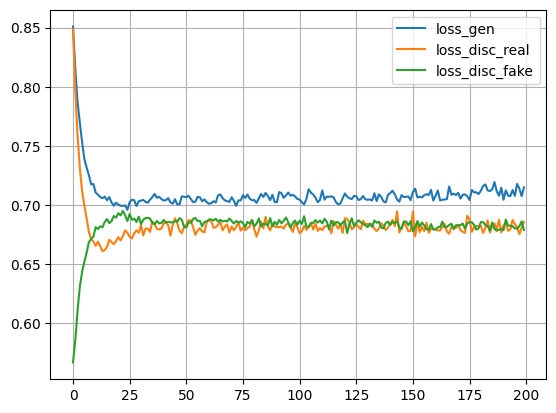

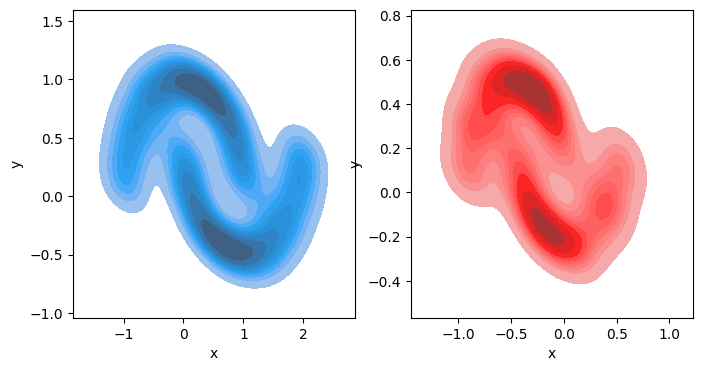

In [ ]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_GAN(gan, moons)

## CycleGAN

In [ ]:
def visualize_CycleGAN(gan_x, gan_y, x, y):
    num = 500
    fake_x = pd.DataFrame(gan_x.gen(y.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    fake_y = pd.DataFrame(gan_y.gen(x.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    x = pd.DataFrame(x, columns=['x', 'y'])
    y = pd.DataFrame(y, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(x, x='x', y='y', fill=True, ax=axs[0][0])
    sns.kdeplot(fake_x, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    sns.kdeplot(y, x='x', y='y', fill=True, ax=axs[1][0])
    sns.kdeplot(fake_y, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    plt.show()

In [ ]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float32)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float32)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [ ]:
class CycleGANTrainer():
    def __init__(self, gan_x, gan_y, lr_disc=1e-3, lr_gen=2e-4):
        self.gan_x = gan_x
        self.gan_y = gan_y
        self.device = gan_x.device
        self.criterion = nn.BCELoss()
        self.cycle_criterion = nn.MSELoss()
        self.optim_disc = torch.optim.Adam([{'params': gan_x.disc.parameters()},
                                            {'params': gan_y.disc.parameters()}], lr=lr_disc)
        # self.optim_disc_y = torch.optim.Adam(gan_y.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam([{'params': gan_x.gen.parameters()},
                                           {'params': gan_y.gen.parameters()}], lr=lr_gen)

    def _init_scheduler(self, epochs):
        lambda_func = lambda epoch: 1 - max(0, epoch - 20) / epochs
        self.lr_scheduler_disc = torch.optim.lr_scheduler.LambdaLR(self.optim_disc, lr_lambda=lambda_func)
        self.lr_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(self.optim_gen, lr_lambda=lambda_func)

    def _train_step_gen(self, x, y):
        """Train the generator one step and return the loss."""
        self.gan_x.gen.zero_grad()
        self.gan_y.gen.zero_grad()
        
        fake_x = self.gan_x.gen(y)
        fake_y = self.gan_y.gen(x)

        loss_identity_x = self.cycle_criterion(fake_y, x)
        loss_identity_y = self.cycle_criterion(fake_x, y)
        loss_identity = (loss_identity_x + loss_identity_y) / 2                        
        
        cls_x = self.gan_x.disc(fake_x)
        cls_y = self.gan_y.disc(fake_y)
        loss_gan_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan = (loss_gan_x + loss_gan_y) / 2

        recov_x = self.gan_x.gen(fake_y)
        recov_y = self.gan_y.gen(fake_x)
        loss_cycle_x = self.cycle_criterion(recov_x, x)
        loss_cycle_y = self.cycle_criterion(recov_y, y)
        loss_cycle = (loss_cycle_x + loss_cycle_y) / 2

        loss = loss_gan + 10*loss_cycle + 5*loss_identity
        loss.backward()
        self.optim_gen.step()
        self.lr_scheduler_gen.step()
        return loss.item()

    def _train_step_disc(self, x, y):
        """Train the discriminator one step and return the losses."""
        self.gan_x.disc.zero_grad()
        self.gan_y.disc.zero_grad()
        
        cls_x = self.gan_x.disc(x)
        cls_y = self.gan_y.disc(y)
        loss_real_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real = (loss_real_x + loss_real_y) / 2

        with torch.no_grad():
            fake_x = self.gan_x.gen(y)
            fake_y = self.gan_y.gen(x)
        cls_fake_x = self.gan_x.disc(fake_x)
        cls_fake_y = self.gan_y.disc(fake_y)
        loss_fake_x = self.criterion(cls_fake_x, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake_y = self.criterion(cls_fake_y, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake = (loss_fake_x + loss_fake_y) / 2
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        self.lr_scheduler_disc.step()
        return loss_real.item(), loss_fake.item()

    def _train_step(self, x, y):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(x, y)
        loss_gen = self._train_step_gen(x, y)
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        self._init_scheduler(epochs * len(dataloader))
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for x, y in dataloader:
                self.batch_size = x.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(x.to(self.device), y.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
LR_D = 1e-3
LR_G = 1e-3

dataset = MoonCircleDataset(10_000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan_x = GAN(device='cuda')
gan_y = GAN(device='cuda')

trainer = CycleGANTrainer(gan_x, gan_y, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

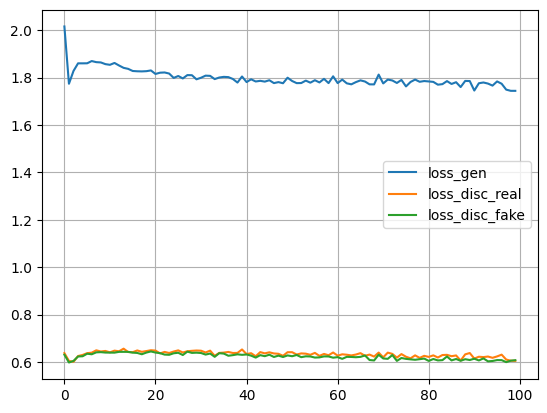

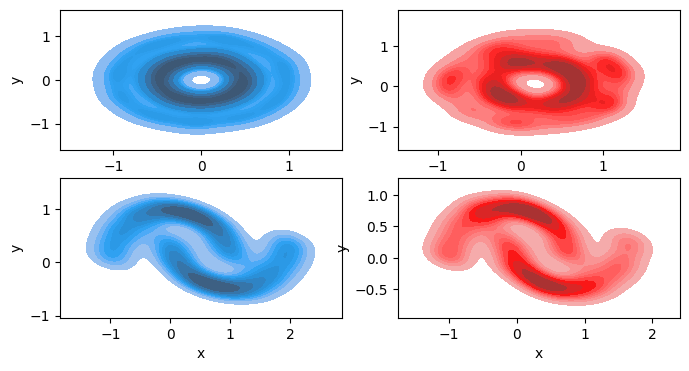

In [ ]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_CycleGAN(gan_x, gan_y, circles, moons)

# Adversarial Schrodinger bridge

In [ ]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.49.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.2.0-cp310-cp310-manylinux_

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1
    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [ ]:
# Define of divergence's conjugate function
forward_kl_conjugate = lambda x: torch.exp(x - 1)
reverse_kl_conjugate = lambda x: -1 - torch.log(-x)
js_conjugate = lambda x: -torch.log(1 - torch.exp(x))

# Define of divergence's activation function
forward_kl_activation = lambda x: x
reverse_kl_activation = lambda x: -torch.exp(-x)
js_activation = lambda x: -torch.log(1 + torch.exp(-x))

# Divergences configuration
divergences = {'forward_kl': {'conj': forward_kl_conjugate, 'activ': forward_kl_activation},
               'reverse_kl': {'conj': reverse_kl_conjugate, 'activ': reverse_kl_activation},
               'js': {'conj': js_conjugate, 'activ': js_activation},
               }

In [ ]:
class fGAN(nn.Module):
    def __init__(self, dim, divergence='js'):
        super().__init__()
        assert divergence in divergences.keys() 

        self.dim = dim
        self.activation = divergences[divergence]['activ']
        self.conjugate = divergences[divergence]['conj']
        self.gen = get_simple_model([dim, 32, 32, 32, dim])
        self.disc = get_simple_model([dim, 32, 32, 32, 1])        

    def sample(self, latent):
        with torch.no_grad():
            samples = self.gen(latent)
        return samples.detach().cpu().numpy()

    


############## TEST ##################
test_dim = 2
f_gan = fGAN(test_dim)
f_gan.sample(torch.rand((4, test_dim))).shape

(4, 2)

In [ ]:
class Conditional(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = get_simple_model([in_dim, 32, 32, 32, 2 * latent_dim])

    def forward(self, x):
        return self.net(x).chunk(2, dim=1)
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 3
test_cond = Conditional(test_in_dim, test_latent_dim)
test_mu, test_log_std = test_cond(torch.rand((4, test_in_dim)))
test_mu.shape, test_log_std.shape

(torch.Size([4, 3]), torch.Size([4, 3]))

In [ ]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p, lr_gen=1e-4, lr_disc=1e-4, lr_cond=1e-4):
        self.batch_size = batch_size
        self.dim  = gan_q.dim

        self.gan_p = gan_p
        self.gan_q = gan_q

        self.conditional_p = conditional_p
        self.conditional_q = conditional_q

        self.marginal_q = marginal_q
        self.marginal_p = marginal_p

        # self.device = conditional_q.device
        self.optim_gen = torch.optim.Adam([{'params': gan_p.gen.parameters()},
                                            {'params': gan_q.gen.parameters()}], lr=lr_gen)
        self.optim_disc = torch.optim.Adam([{'params': gan_p.disc.parameters()},
                                            {'params': gan_q.disc.parameters()}], lr=lr_disc)
        self.optim_cond = torch.optim.Adam([{'params': conditional_p.parameters()},
                                            {'params': conditional_q.parameters()}], lr=lr_cond)
        
    def train(self, iterations):
        # avg_loss_gen_b, avg_loss_disc_b = 0, 0
        # avg_loss_gen_f, avg_loss_disc_f = 0, 0

        losses = {
            'forward': {'gen': [], 'disc': []},
            'backward': {'gen': [], 'disc': []}
        }

        for iteration in range(iterations):
            # Sample true data
            x = self.marginal_q.sample([self.batch_size, self.dim])
            y = self.marginal_p.sample([self.batch_size, self.dim])

            # Make backward step
            loss_gen_b, loss_disc_b = self._backward_step(y, x)
            losses['backward']['gen'].append(loss_gen_b)
            losses['backward']['disc'].append(loss_disc_b)

            # Make forward step
            loss_gen_f, loss_disc_f = self._forward_step(x, y)
            losses['forward']['gen'].append(loss_gen_f)
            losses['forward']['disc'].append(loss_disc_f)
            
            if iteration % 50 == 0:
                print(f'Iteration: {iteration}; forward: gen: {loss_gen_f}, disc: {loss_disc_f}; backward: gen: {loss_gen_b}, disc: {loss_disc_b}')
        return losses
        
    def _backward_step(self, y, x):
        loss_gen = self._train_step_gen(y, self.gan_p, self.conditional_p, self.conditional_q, self.marginal_q)
        loss_disc = self._train_step_disc(self.gan_p, y, x)
        return loss_gen, loss_disc

    def _forward_step(self, x, y):
        loss_gen = self._train_step_gen(x, self.gan_q, self.conditional_q, self.conditional_p, self.marginal_p)
        loss_disc = self._train_step_disc(self.gan_q, x, y)
        return loss_gen, loss_disc
    
    def _train_step_gen(self, latent, gan, cond, cond_fixed, marginal):
        self.optim_gen.zero_grad()
        self.optim_cond.zero_grad()

        # Generate samples
        samples = gan.gen(latent)

        # Generator loss
        loss_gen = -gan.activation(gan.disc(samples)).mean()
        
        # Condition distribution loss
        mu, log_std = cond(samples)
        cond_dist = Normal(mu, torch.exp(log_std))
        with torch.no_grad():
            mu_fixed, log_std_fixed = cond_fixed(latent)
            cond_fixed_dist = Normal(mu_fixed, torch.exp(log_std_fixed))

        loss_conditional = kl_divergence(cond_dist, cond_fixed_dist).mean()

        # Cross entropy loss
        loss_ce = -marginal.log_prob(samples).mean()
        
        loss = loss_gen + loss_conditional + loss_ce
        loss.backward()
        self.optim_gen.step()
        self.optim_cond.step()
        
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, gan, real, latent):
        self.optim_disc.zero_grad()

        # calc real loss
        pred_real = gan.disc(real)
        loss_real = gan.activation(pred_real).mean()

        # generated samples        
        with torch.no_grad():
            fake_samples = gan.gen(latent)
        pred_fake = gan.disc(fake_samples)
        loss_fake = gan.conjugate(gan.activation(pred_fake)).mean()

        # combine
        loss = loss_fake - loss_real
        loss.backward()
        self.optim_disc.step()
        return loss.detach().cpu().item()


# Experiments


## Unimodal experiments: 
1. $\pi_0(x) = \mathcal{N}(5, 1)$; $\pi_1(y) = \mathcal{N}(-2, 1)$
2. $\pi_0(x) = \mathcal{N}(0, 9)$; $\pi_1(y) = \mathcal{N}(20, 0.5^2)$

### Jense-Shannnon div

In [ ]:
gan_p = fGAN(1)
gan_q = fGAN(1)
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(5000)

Iteration: 0; forward: gen: 5.567203998565674, disc: 1.4206578731536865; backward: gen: 15.045125007629395, disc: 1.4004572629928589
Iteration: 50; forward: gen: 3.932807445526123, disc: 1.3531816005706787; backward: gen: 12.392641067504883, disc: 1.3878079652786255
Iteration: 100; forward: gen: 3.731691360473633, disc: 1.3399369716644287; backward: gen: 11.589470863342285, disc: 1.3654279708862305
Iteration: 150; forward: gen: 3.5221714973449707, disc: 1.3361897468566895; backward: gen: 11.00167179107666, disc: 1.3275864124298096
Iteration: 200; forward: gen: 3.3385627269744873, disc: 1.3052935600280762; backward: gen: 10.524876594543457, disc: 1.341975450515747
Iteration: 250; forward: gen: 3.178516387939453, disc: 1.2901792526245117; backward: gen: 10.024022102355957, disc: 1.3298617601394653
Iteration: 300; forward: gen: 2.9912872314453125, disc: 1.2639310359954834; backward: gen: 9.558289527893066, disc: 1.3126851320266724
Iteration: 350; forward: gen: 2.893632173538208, disc: 1.2

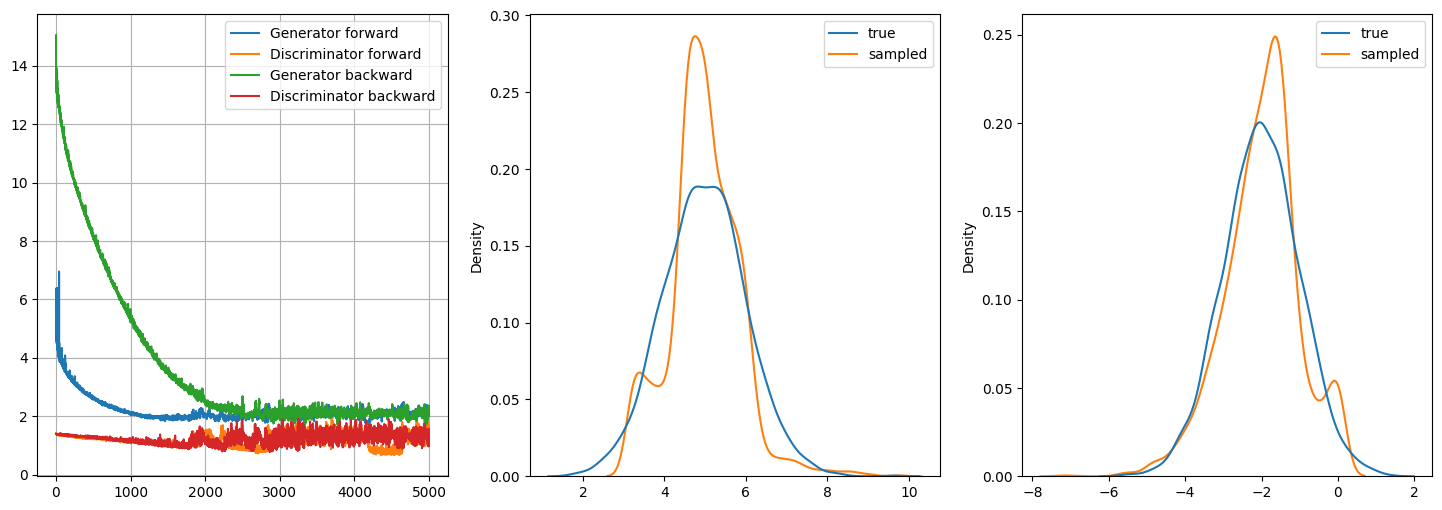

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()

### KL-divergence

In [ ]:
gan_p = fGAN(1, 'forward_kl')
gan_q = fGAN(1, 'forward_kl')
conditional_p = Conditional(1, 32)
conditional_q = Conditional(1, 32)
marginal_q = Normal(5, 1)
marginal_p = Normal(-2, 1)

trainer = AdversarialIPFPTrainer(32, gan_p, gan_q, conditional_p, conditional_q, marginal_q, marginal_p)
losses = trainer.train(4000)

Iteration: 0; forward: gen: 5.3302001953125, disc: 0.6851273775100708; backward: gen: 13.829456329345703, disc: 0.3780667781829834
Iteration: 50; forward: gen: 4.340636253356934, disc: 0.5908280611038208; backward: gen: 12.545273780822754, disc: 0.25739359855651855
Iteration: 100; forward: gen: 3.891781806945801, disc: 0.5418280959129333; backward: gen: 11.701598167419434, disc: 0.18822205066680908
Iteration: 150; forward: gen: 3.450451374053955, disc: 0.4111766815185547; backward: gen: 11.121711730957031, disc: 0.1235705316066742
Iteration: 200; forward: gen: 3.216791868209839, disc: 0.38433194160461426; backward: gen: 10.508024215698242, disc: 0.05706071853637695
Iteration: 250; forward: gen: 2.914079189300537, disc: 0.30258098244667053; backward: gen: 9.994415283203125, disc: 0.013625264167785645
Iteration: 300; forward: gen: 2.6816565990448, disc: 0.18500342965126038; backward: gen: 9.474943161010742, disc: -0.0038412809371948242
Iteration: 350; forward: gen: 2.562268018722534, dis

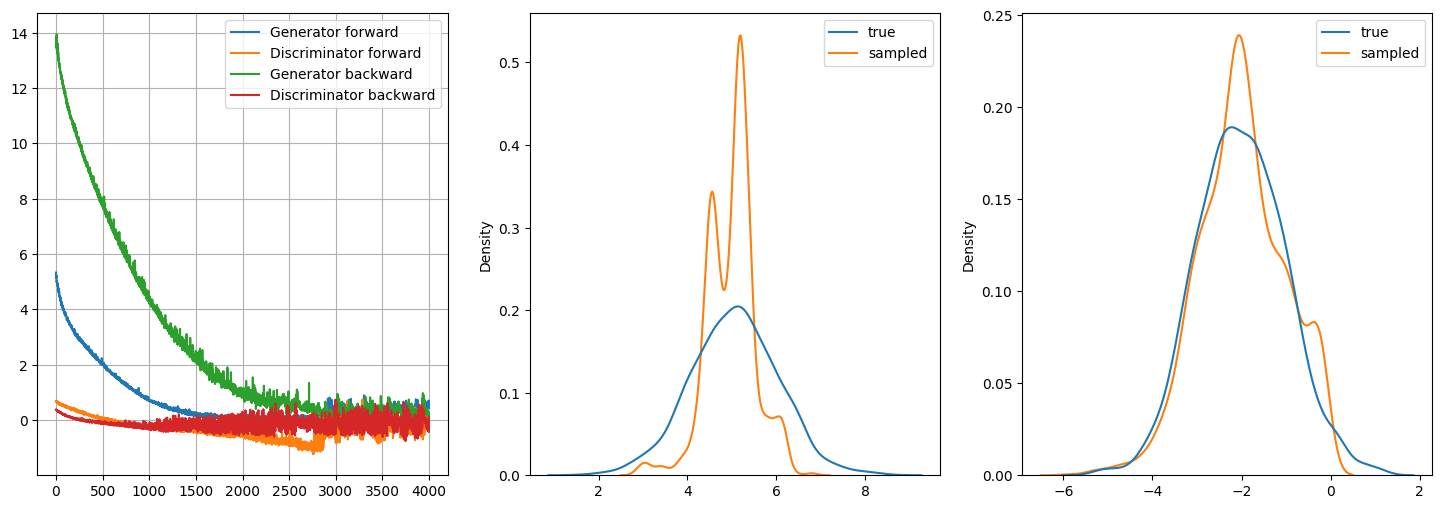

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Plot losses
axs[0].plot(losses['forward']['gen'], label='Generator forward')
axs[0].plot(losses['forward']['disc'], label='Discriminator forward')
axs[0].plot(losses['backward']['gen'], label='Generator backward')
axs[0].plot(losses['backward']['disc'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

# Plot samples 
n_samples = 2000
true_x = marginal_q.sample([n_samples, 1])
true_y = marginal_p.sample([n_samples, 1])

sampled_x = gan_p.sample(true_y)
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1])

sampled_y = gan_q.sample(true_x)
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[2])

plt.show()


## Multimodal experiment
3. $\pi_0(x) = \mathcal{N}(0, 1)$; $\pi_1(y) = \frac12 \mathcal{N}(20, 0.5^2) + \frac12 \mathcal{N}(-20, 0.5^2)$ 

# Experiments Variational Repersentation


In [ ]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.49.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Model implementation

In [ ]:
def get_simple_model(hiddens, activation=nn.ReLU(), last_activation=None):
    assert len(hiddens) > 1
    modules = []
    for i, (in_, out_) in enumerate(zip(hiddens[:-2], hiddens[1:-1])):
        # modules.extend([nn.Linear(in_, out_), nn.ELU()]) # nn.BatchNorm1d(out_), nn.ReLU()])
        if i != len(hiddens) - 3 or not last_activation:
            modules.extend([nn.Linear(in_, out_), nn.BatchNorm1d(out_), activation])
        else:
            modules.extend([nn.Linear(in_, out_), nn.BatchNorm1d(out_), last_activation])
    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
    return nn.Sequential(*modules)

In [ ]:
def visualize(cond_p, cond_q, dataset):
    circles, moons = dataset.circles[:2_000], dataset.moons[:2_000]
    
    fake_circles = pd.DataFrame(cond_p.sample(moons).detach().numpy(), columns=['x', 'y'])
    fake_moons = pd.DataFrame(cond_q.sample(circles).detach().numpy(), columns=['x', 'y'])
    circles = pd.DataFrame(circles, columns=['x', 'y'])
    moons = pd.DataFrame(moons, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(circles, x='x', y='y', fill=True, ax=axs[0][0])
    axs[0][0].set_title("Circles")
    sns.kdeplot(fake_circles, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    axs[0][1].set_title("Fake Circles")
    sns.kdeplot(moons, x='x', y='y', fill=True, ax=axs[1][0])
    axs[1][0].set_title("Moons")
    sns.kdeplot(fake_moons, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    axs[1][1].set_title("Fake Moons")
    plt.show()

Forward:
$$
\mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q(y|x)}D(x,y) - \mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p^*(x|y)}e^{D(x,y)-1}
$$
Backward:
$$
\mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p(x|y)}D(x,y) - \mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q^*(y|x)}e^{D(x,y)-1}
$$
Algorithm:
1. Sample real $x$, $y$
2. Sample fake $x$, $y$ from conditional pdf $p(x|y)$ and $q(y|x)$
3. Calculate expectation loss

In [ ]:
# Define of divergence's conjugate function
class Conjugate(nn.Module):
    conjugates = {
        'forward_kl': lambda x: torch.exp(x - 1),
        'reverse_kl': lambda x: -1 - torch.log(-x),
        'js': lambda x: -torch.log(1 - torch.exp(x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.conjugates.keys() 
        self.conjugate = self.conjugates[divergence]

    def forward(self, x):
        return self.conjugate(x)

# Define of divergence's activation function
class Activation(nn.Module):
    activations = {
        'forward_kl': lambda x: x,
        'reverse_kl': lambda x: -torch.exp(-x),
        'js': lambda x: -torch.log(1 + torch.exp(-x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.activations.keys() 
        self.activation = self.activations[divergence]

    def forward(self, x):
        return self.activation(x)

In [ ]:
class Conditional(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.in_dim = in_dim        
        # self.net = get_simple_model([in_dim, 32, 32, 32, in_dim], last_activation=nn.Tanh())
        self.net = get_simple_model([in_dim, 32, 32, 32, 2 * in_dim], last_activation=nn.Tanh())

    def forward(self, x):
        return self.net(x).chunk(2, dim=1)
        # return self.net(x)

    def sample(self, x):
        mu, log_std = self(x)
        return torch.exp(log_std) * self._prior(self.in_dim) + mu
        # return mu
        # return self(x)

    def _prior(self, n):
        return Normal(.0, 1.).sample([n])
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 2
test_cond = Conditional(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_cond.sample(test_x)
test_cond

Conditional(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, divergence='forward_kl'):
        super().__init__()
        self.in_dim = in_dim
        
        self.conjugate = Conjugate(divergence)
        # self.net_x = get_simple_model([in_dim, 32, 32])
        # self.net_y = get_simple_model([in_dim, 32, 32])
        # self.final = get_simple_model([2 * 32, 32, 1])
        self.final = get_simple_model([2 * in_dim, 32, 32, 32, 1], nn.LeakyReLU(0.1))
        self.final.add_module("activation", Activation(divergence))

    def forward(self, x, y, conjugate=False):
        # x = self.net_x(x)
        # y = self.net_y(y)
        x_y = torch.concat([x, y], dim=1)
        return self.final(x_y) if not conjugate else self.conjugate(self.final(x_y))

############## TEST ##################
test_in_dim = 2
test_disc = Discriminator(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_y = torch.rand((4, test_in_dim))
test_disc(test_x, test_y)
test_disc

Discriminator(
  (conjugate): Conjugate()
  (final): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (activation): Activation()
  )
)

In [ ]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, cond_p, cond_q, disc_b, disc_f, lr_gen=1e-4, lr_disc=1e-4):
        self.batch_size = batch_size
        self.dim  = cond_p.in_dim

        self.cond_p = cond_p # x|y
        self.cond_q = cond_q # y|x
        self.disc_b = disc_b
        self.disc_f = disc_f

        self.optim_gen = torch.optim.Adam([{'params': cond_p.parameters()},
                                            {'params': cond_q.parameters()}], lr=lr_gen) #, weight_decay=0.5, betas=(0.5, 0.999))
        self.optim_disc = torch.optim.Adam([{'params': disc_b.parameters()},
                                            {'params': disc_f.parameters()}], lr=lr_disc) #, weight_decay=0.5, betas=(0.5, 0.999))

    def _init_scheduler(self, epochs):
        lambda_func = lambda epoch: 1 - max(0, epoch - 20) / epochs
        self.lr_scheduler_disc = torch.optim.lr_scheduler.LambdaLR(self.optim_disc, lr_lambda=lambda_func)
        self.lr_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(self.optim_gen, lr_lambda=lambda_func)
        
    def train(self, dataloader, epochs=200, verbose=10):
        losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

        # self._init_scheduler(epochs * len(dataloader))        
        for epoch in range(epochs):
            avg_loss_cond_p, avg_loss_cond_q, avg_loss_disc_b, avg_loss_disc_f = 0, 0, 0, 0
            avg_kl_div_b, avg_kl_div_f = 0, 0
            
            for batch in dataloader:
                x, y = batch # circles, moons
                # for _ in range(iterations):
                loss_cond_p, loss_disc_b, kl_div_b = self._backward_step(x, y)
                avg_loss_cond_p += loss_cond_p
                avg_loss_disc_b += loss_disc_b
                avg_kl_div_b += kl_div_b
                
            print(f'Backward True: {avg_kl_div_b / len(dataloader)}; Approx: {avg_loss_disc_b / len(dataloader)}')
            
            for batch in dataloader:
                x, y = batch # circles, moons
                # for _ in range(iterations):
                loss_cond_q, loss_disc_f, kl_div_f = self._forward_step(x, y)
                avg_loss_cond_q += loss_cond_q
                avg_loss_disc_f += loss_disc_f
                avg_kl_div_f += kl_div_f
            
            # self.lr_scheduler_gen.step()
            # self.lr_scheduler_disc.step()
            print(f'Forward True: {avg_kl_div_f / len(dataloader)}; Approx: {avg_loss_disc_f / len(dataloader)}')
            
            losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
            losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
            losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
            losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
            
            # if (epoch + 1) % verbose == 0:
            #     print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')
        return losses
        
    def _backward_step(self, x, y):
        loss_cond = self._train_step_gen(y, self.cond_p, self.disc_b)
        # for _ in range(10):
        loss_disc, kl_div = self._train_step_disc(y, x, self.cond_p, self.cond_q, self.disc_b)
        return loss_cond, loss_disc, kl_div

    def _forward_step(self, x, y):
        loss_cond = self._train_step_gen(x, self.cond_q, self.disc_f)
        # for _ in range(10):
        loss_disc, kl_div = self._train_step_disc(x, y, self.cond_q, self.cond_p, self.disc_f)
        return loss_cond, loss_disc, kl_div
    
    def _train_step_gen(self, latent, cond, disc):
        self.optim_gen.zero_grad()

        # Generate fake samples
        generated = cond.sample(latent)
        
        loss = disc(latent, generated).mean()
        loss.backward()
        self.optim_gen.step()
        # self.lr_scheduler_gen.step()
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, latent, real, cond, cond_fixed, disc, calc_kl_div=True):
        kl_div = None
        self.optim_disc.zero_grad()
        
        # calc training cond loss
        # generated_real = cond.sample(latent)
        mu, log_std = cond(latent)
        generated_real = torch.exp(log_std) * cond._prior(cond.in_dim) + mu
            
        loss_training = disc(latent, generated_real).mean()

        # calc fixed cond loss
        with torch.no_grad():
            # generated_latent = cond_fixed.sample(real)
            mu_fixed, log_std_fixed = cond_fixed(real)          
            generated_latent = torch.exp(log_std) * cond_fixed._prior(cond_fixed.in_dim) + mu
            
        loss_fixed = disc(generated_latent, real, conjugate=True).mean()

        # combine
        loss = loss_fixed - loss_training
        loss.backward()
        self.optim_disc.step()
        
        # self.lr_scheduler_disc.step()
        if calc_kl_div:
            pdf = Normal(mu, torch.exp(log_std))
            pdf_fixed = Normal(mu_fixed, torch.exp(log_std_fixed))
            kl_div = kl_divergence(pdf, pdf_fixed).mean()
            
        return loss.detach().cpu().item(), kl_div.detach().cpu().item()

## Dataloader

In [ ]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float32)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float32)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

## Training

In [ ]:
# Models parameters
data_dim = 2
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)


# Trainer and dataloader parameters
batch_size = 128

dataset = MoonCircleDataset(60_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen=1e-4, lr_disc=1e-4
)
losses = trainer.train(dataloader, epochs=20, verbose=1)

Backward True: 0.5796712542901924; Approx: 0.19158173652727212
Forward True: 1.632182189650627; Approx: 0.17058760547307508
Backward True: 4.728556899627897; Approx: 0.15004748820877278
Forward True: 9.164847651778508; Approx: 0.1497215091991526
Backward True: 15.334465842511355; Approx: 0.043758460866616986
Forward True: 18.092534882935887; Approx: 0.09500123160098915
Backward True: 23.89830227116786; Approx: -0.07045978406217815
Forward True: 28.56645317753749; Approx: 0.04047752135216808
Backward True: 29.807331438766106; Approx: -0.12779184086109274
Forward True: 31.488346672769804; Approx: -0.0527827940833594
Backward True: 31.353572337993427; Approx: -0.2602895339097041
Forward True: 33.77247166938619; Approx: -0.14052646669116356
Backward True: 33.79061842053684; Approx: -0.4247444963086643
Forward True: 35.95203358506851; Approx: -0.2730344729954754
Backward True: 36.81931403794014; Approx: -0.6337643547543584
Forward True: 38.47482613637757; Approx: -0.4655521661043167
Backwar

KeyboardInterrupt: 

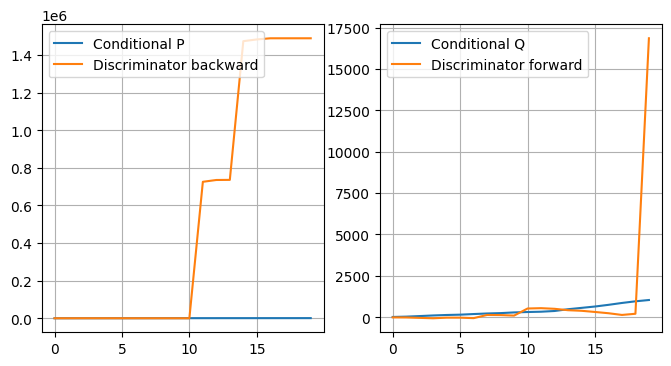

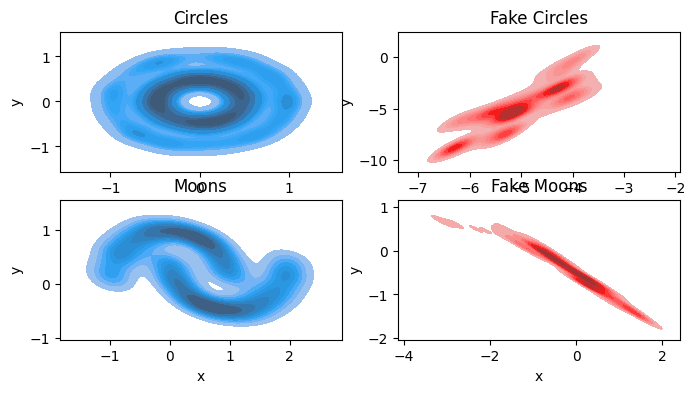

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Plot losses
axs[0].plot(losses['cond_p'], label='Conditional P')
axs[0].plot(losses['disc_b'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

axs[1].plot(losses['cond_q'], label='Conditional Q')
axs[1].plot(losses['disc_f'], label='Discriminator forward')
axs[1].grid()
axs[1].legend()

# plt.grid()
# plt.legend()
visualize(conditional_p, conditional_q, dataset)

### For onevariate dataset calculate kl div using marginal and conditional

In [ ]:
class OneVariateDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = Normal(-2, 1).sample([size, 1])
        self.moons = Normal(5, 1).sample([size, 1])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [ ]:
# Models parameters
data_dim = 1
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)

# Trainer and dataloader parameters
batch_size = 32

dataset = OneVariateDataset(60_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen=1e-4, lr_disc=1e-4
)
losses = trainer.train(dataloader, epochs=100, verbose=10)

Iteration: 10; cond_p: 12.500078262524182, cond_q: 11.552245009546478, disc_f: -1.7753477542797724, disc_b: -2.6760320787032446
Iteration: 20; cond_p: 26.927800388229265, cond_q: 27.139884618199865, disc_f: -7.076131464282672, disc_b: -6.859630878822009
Iteration: 30; cond_p: 42.2768038794402, cond_q: 42.9405039415131, disc_f: -12.619423938854535, disc_b: -11.753112993629774
Iteration: 40; cond_p: 58.39272309003112, cond_q: 60.58012183797459, disc_f: -15.78922136045297, disc_b: -17.50484386123816
Iteration: 50; cond_p: 78.01370946580954, cond_q: 81.52932065548649, disc_f: -26.717089338676136, disc_b: -26.880904388801255
Iteration: 60; cond_p: 100.32383566892706, cond_q: 105.5464756800736, disc_f: -40.8166565195481, disc_b: -39.08656831880808
Iteration: 70; cond_p: 123.97159910785096, cond_q: 131.5499428153639, disc_f: -57.03535621741613, disc_b: -40.49533295091788
Iteration: 80; cond_p: 133.09994501620343, cond_q: 147.28122540034653, disc_f: -58.988364352194466, disc_b: -36.87289147915

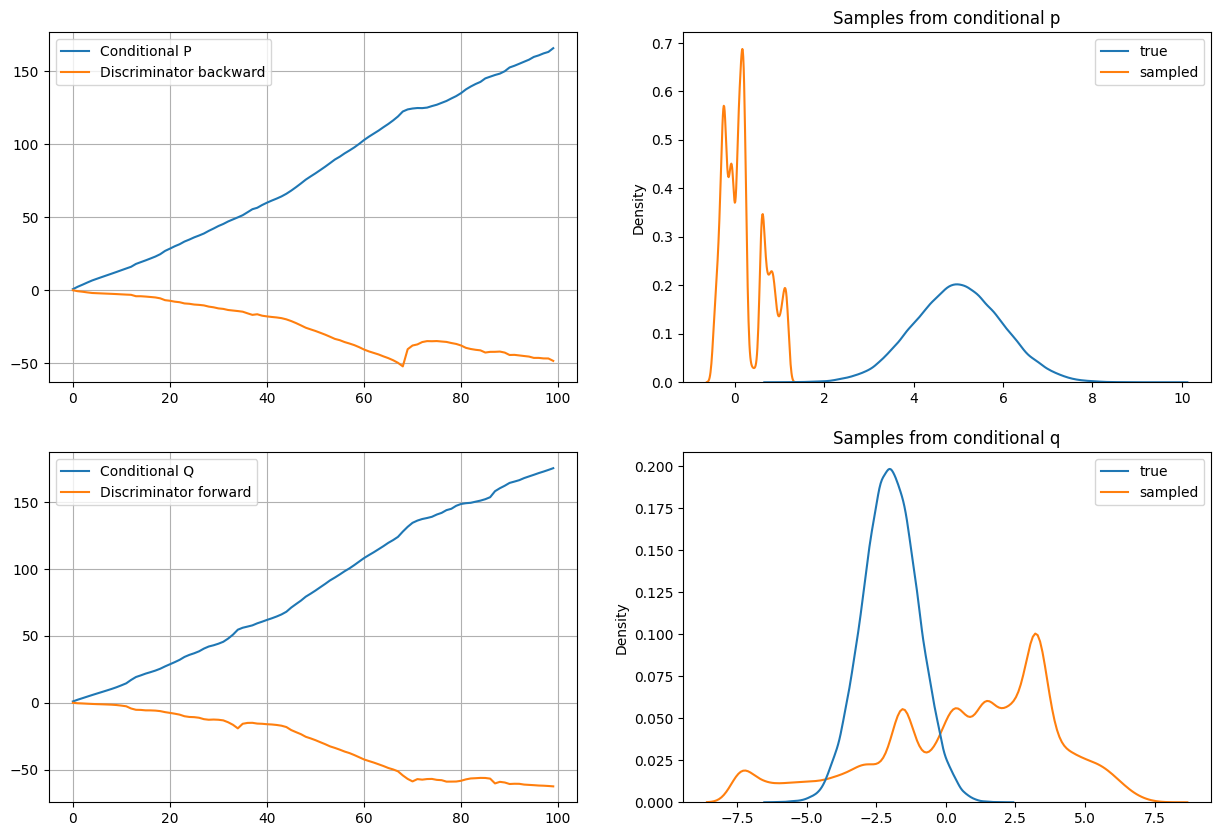

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 2000
true_x, true_y = dataset[:]

sampled_x = conditional_q.sample(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q")

sampled_y = conditional_p.sample(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p")

plt.show()

# IPFP algh wiht true kl div

In [1]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm torch

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torch.nn.functional as F

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Model implementation

In [38]:
def visualize(joint_p, joint_q, n_samples=1_000):
    samples_p = MultivariateNormal(joint_p.mu, scale_tril=torch.diag(joint_p.cov)).sample([n_samples])
    samples_q = MultivariateNormal(joint_q.mu, scale_tril=torch.diag(joint_q.cov)).sample([n_samples])
    
    x, y = samples_p.chunk(2, dim=1)
    df_p = {'x': x.squeeze(), 'y': y.squeeze(), 'Distribution': 'Joint P'}
    df_p = pd.DataFrame(df_p)
    
    x, y = samples_q.chunk(2, dim=1)
    df_q = {'x': x.squeeze(), 'y': y.squeeze(), 'Distribution': 'Joint Q'}
    df_q = pd.DataFrame(df_q)
        
    sns.kdeplot(data=pd.concat([df_p, df_q]), x="x", y="y", hue='Distribution', fill=True, alpha=.6)
    plt.grid()
    plt.show()

In [39]:
class Joint(nn.Module):
    def __init__(self, in_dim, mu_fixed, div_fixed, left=True):
        super().__init__()
        # train only second half in mu prameter
        mu = torch.zeros(2 * in_dim) 
        if left: mu[:in_dim] = mu_fixed 
        else: mu[in_dim:] = mu_fixed
        self.mu = nn.Parameter(mu)

        cov = torch.ones(2 * in_dim)
        if left: cov[:in_dim] = div_fixed
        else: cov[in_dim:] = div_fixed
        self.cov = nn.Parameter(cov)
        

        # make mask of size mu
        self.mu_mask = torch.ones_like(self.mu)
        if left: self.mu_mask[:in_dim] = 0
        else: self.mu_mask[in_dim:] = 0
        self.mu.register_hook(lambda grad: grad * self.mu_mask)
        
        # make mask of size cov
        self.cov_mask = torch.ones_like(self.cov)
        if left: self.cov_mask[:in_dim] = 0
        else: self.cov_mask[in_dim:] = 0
        self.cov.register_hook(lambda grad: grad * self.cov_mask)

    def forward(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        return MultivariateNormal(self.mu, scale_tril=torch.diag(self.cov)).log_prob(x_y)
    
def compute_kl_divergence(log_probs_p, log_probs_q):
    """"KL (p || q)"""
    kl_div = torch.exp(log_probs_p) * (log_probs_p - log_probs_q)
    return kl_div.sum()

    
############## TEST ##################
test_in_dim = 1
test_mu1 = -2
test_mu2 = 5
test_div = 1
test_joint1 = Joint(test_in_dim, test_mu1, test_div, left=True)
test_joint2 = Joint(test_in_dim, test_mu2, test_div, left=False)

test_x = torch.rand((32, test_in_dim))
test_y = torch.rand((32, test_in_dim))

log_probs1 = test_joint1(test_x, test_y)
log_probs2 = test_joint2(test_x, test_y)

compute_kl_divergence(log_probs1, log_probs2).backward()
print(test_joint2.mu.grad)
print(test_joint2.cov.grad)
test_joint2.cov.shape

tensor([-0.0758,  0.0000])
tensor([0.1355, -0.0000])


torch.Size([2])

In [50]:
class IPFPTrainer:
    def __init__(self, batch_size, joint_p, joint_q, lr_mu=1e-4, lr_cov=1e-4):
        self.batch_size = batch_size

        self.joint_p = joint_p
        self.joint_q = joint_q

        self.optim_mu = torch.optim.Adam([{'params': joint_p.mu}, {'params': joint_q.mu}], lr=lr_mu)
        self.optim_cov = torch.optim.Adam([{'params': joint_p.cov}, {'params': joint_q.cov}], lr=lr_cov)
   
        
    def train(self, epochs=200, verbose=10):
        losses = {'joint_p': [], 'joint_q': []}

        for epoch in range(epochs):
            avg_loss_joint_p, avg_loss_joint_q = 0, 0
            x, y = MultivariateNormal(self.joint_p.mu, scale_tril=torch.diag(self.joint_p.cov)).sample([self.batch_size]).chunk(2, dim=1)
            # x, y = batch
            loss_joint_p = self._backward_step(x, y)
            avg_loss_joint_p += loss_joint_p
                            
            # for batch in dataloader:
            # x, y = batch
            x, y = MultivariateNormal(self.joint_q.mu, scale_tril=torch.diag(self.joint_q.cov)).sample([self.batch_size]).chunk(2, dim=1)
            loss_joint_q = self._forward_step(x, y)
            avg_loss_joint_q += loss_joint_q
            
            losses['joint_p'].append(avg_loss_joint_p / self.batch_size)
            losses['joint_q'].append(avg_loss_joint_q / self.batch_size)
            
            if (epoch + 1) % verbose == 0:
                visualize(self.joint_p, self.joint_q)
                print(f'Iteration: {epoch + 1}; joint_p: {losses["joint_p"][-1]}; joint_q: {losses["joint_q"][-1]}')
        return losses
        
    def _backward_step(self, x, y):
        self.optim_mu.zero_grad()
        self.optim_cov.zero_grad()
        log_probs_p = self.joint_p(x, y)
        with torch.no_grad():
            log_probs_q = self.joint_q(x, y)
        loss_joint = compute_kl_divergence(log_probs_p, log_probs_q)
        loss_joint.backward()
        self.optim_mu.step()
        self.optim_cov.step()
        return loss_joint.detach().cpu().item()

    def _forward_step(self, x, y):
        self.optim_mu.zero_grad()
        self.optim_cov.zero_grad()
        log_probs_q = self.joint_q(x, y)
        with torch.no_grad():
            log_probs_p = self.joint_p(x, y)
        loss_joint = compute_kl_divergence(log_probs_q, log_probs_p)
        loss_joint.backward()
        self.optim_mu.step()
        self.optim_cov.step()
        return loss_joint.detach().cpu().item()

## Dataloader

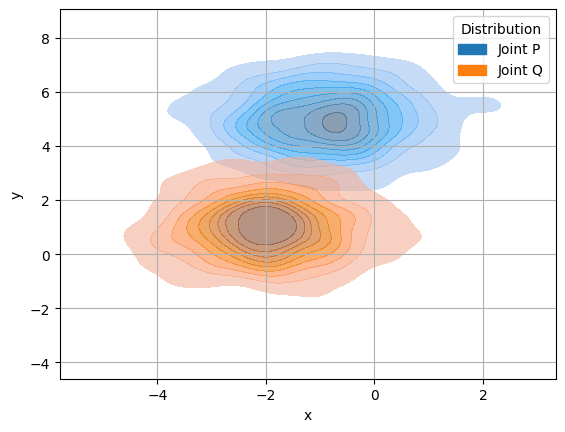

Iteration: 100; joint_p: 0.6912046463213762; joint_q: 0.6836197249420449


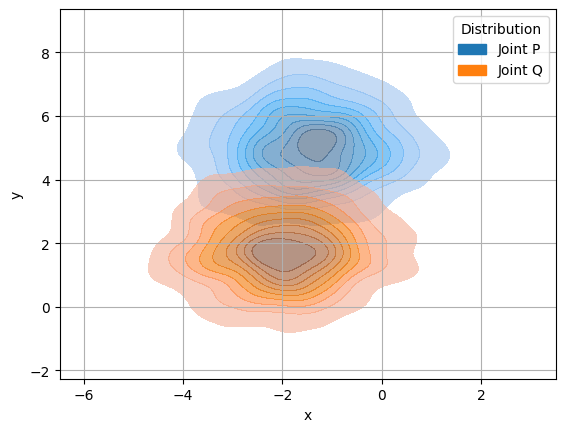

Iteration: 200; joint_p: 0.3975607861304295; joint_q: 0.4101417731400988


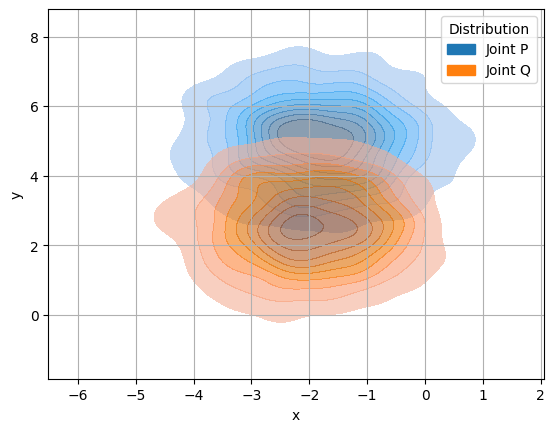

Iteration: 300; joint_p: 0.22431721647755; joint_q: 0.23615091751120973


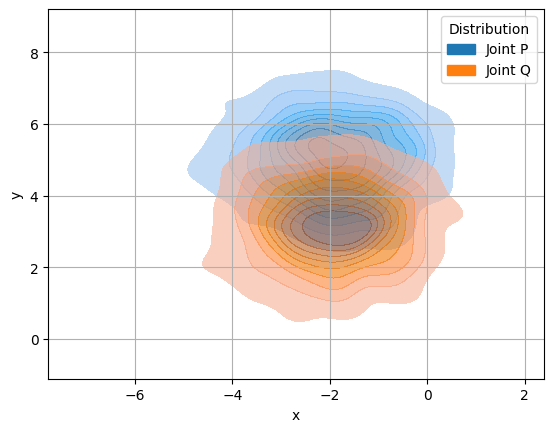

Iteration: 400; joint_p: 0.1234013197653581; joint_q: 0.13220882089967667


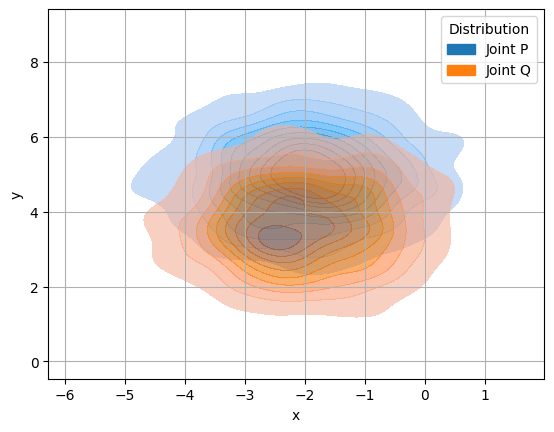

Iteration: 500; joint_p: 0.0653715640990079; joint_q: 0.06854589861622666


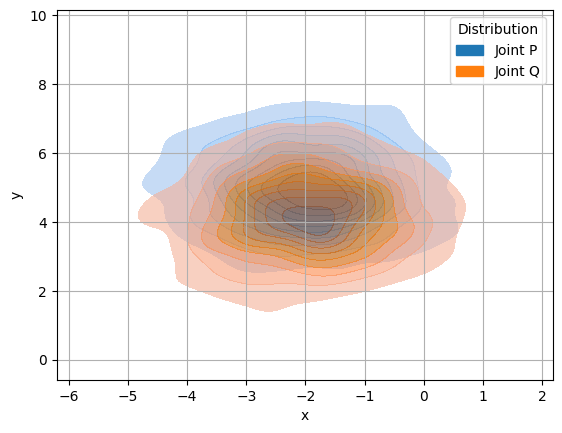

Iteration: 600; joint_p: 0.030762482061800343; joint_q: 0.033442972461557086


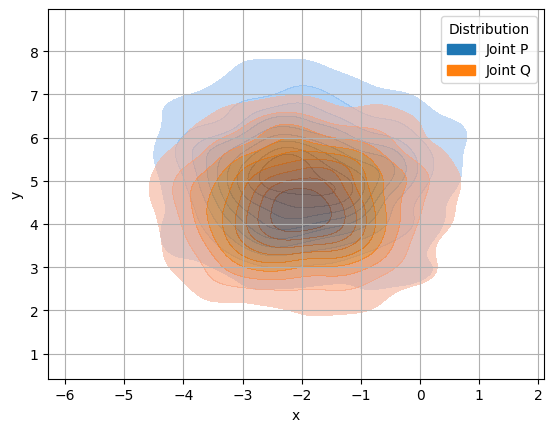

Iteration: 700; joint_p: 0.014400313690617469; joint_q: 0.015886642806061075


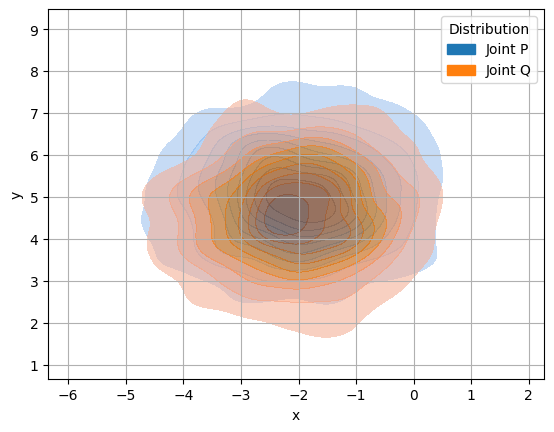

Iteration: 800; joint_p: 0.006627901523156303; joint_q: 0.006410514976758384


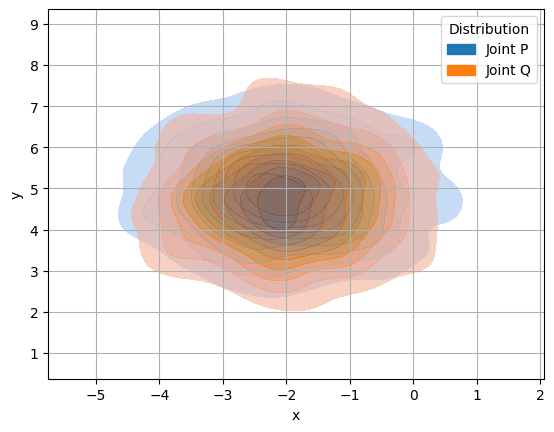

Iteration: 900; joint_p: 0.002100029941184629; joint_q: 0.0023950141135979535


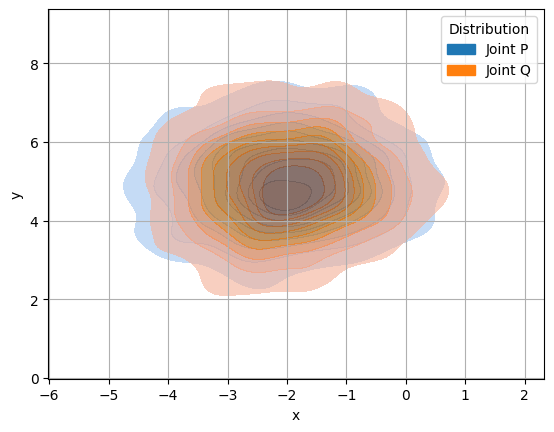

Iteration: 1000; joint_p: 0.0009076548181201494; joint_q: 0.0009639112468810707


In [64]:
# Models parameters
data_dim = 1

mu_p = 5
mu_q = -2
div_p = 1
div_q = 1

joint_p = Joint(data_dim, mu_p, div_p, left=False)
joint_q = Joint(data_dim, mu_q, div_q, left=True)

# Trainer and dataloader parameters
batch_size = 4098

trainer = IPFPTrainer(
    batch_size,
    joint_p,
    joint_q,
    lr_mu=1e-2,
    lr_cov=1e-4
)
losses = trainer.train(epochs=1000, verbose=100)

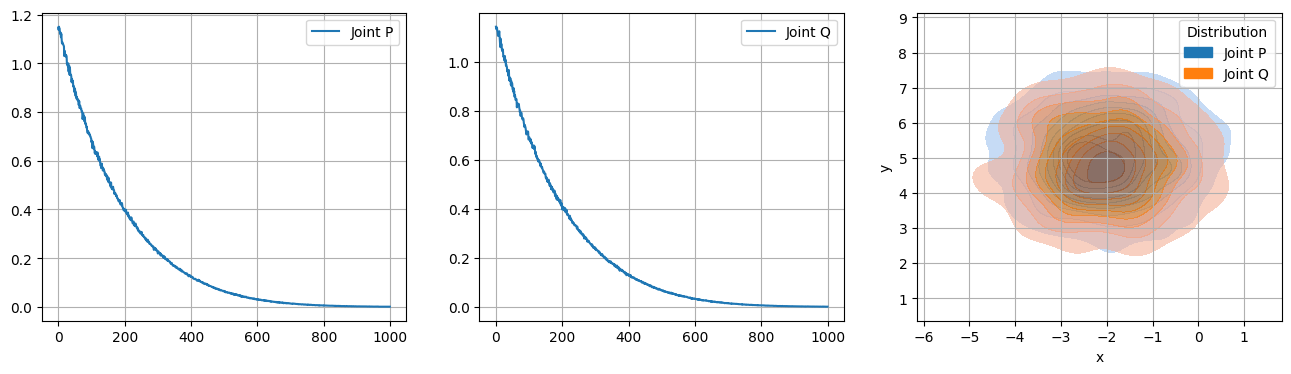

True x: mu=-2, std=1
True y: mu=5, std=1
q(x, y): mu=tensor([-2.0000,  4.8524]), std=tensor([1.0000, 1.0396])
p(x, y): mu=tensor([-1.9996,  5.0000]), std=tensor([1.0392, 1.0000])


In [65]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
# Plot losses
axs[0].plot(losses['joint_p'], label='Joint P')
axs[0].grid() 
axs[0].legend()

axs[1].plot(losses['joint_q'], label='Joint Q')
axs[1].grid()
axs[1].legend()

# Plot samples 
visualize(joint_p, joint_q)
plt.show()

print(f'True x: mu={-2}, std={1}')
print(f'True y: mu={5}, std={1}')
print(f'q(x, y): mu={joint_q.mu.detach()}, std={(joint_q.cov).detach()}')
print(f'p(x, y): mu={joint_p.mu.detach()}, std={(joint_p.cov).detach()}')